In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git




1.12.1+cu113
     |████████████████████████████████| 8.9 MB 345 kB/s 
     |████████████████████████████████| 3.5 MB 2.6 MB/s 
     |████████████████████████████████| 280 kB 5.1 MB/s 


In [ ]:
# # Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


# Node Classification with Graph Neural Networks

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

The Cora dataset contains 2708 papers from 7 categories:
Neural Networks, Case Based, Reinforcement Learning, Probabilistic Methods, Genetic Algorithms, Rule Learning, and
Theory

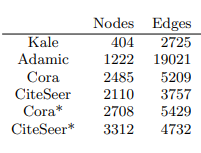

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

`
Row-normalizes the attributes given in attrs to sum-up to one (functional name: normalize_features).
`

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
import torch
from torch.nn import Linear, Conv1d
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
import torch
from torch.nn import Linear,  Conv1d
import torch.nn.functional as F


class CNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        # self.conv1 = Conv1d(dataset.num_features, hidden_channels, kernel_size = 2)
        self.conv1 = Conv1d(data.num_features, hidden_channels, kernel_size = 1)

        self.conv2 = Conv1d(hidden_channels, dataset.num_classes,  kernel_size = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x)
        return x

model = CNN(hidden_channels=16)
print(model)

CNN(
  (conv1): Conv1d(1433, 16, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(16, 7, kernel_size=(1,), stride=(1,))
)


In [ ]:
dataset.num_features

1433

Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
pip install py2cytoscape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 2.6 MB/s 
     |████████████████████████████████| 3.3 MB 10.8 MB/s 
  Created wheel for py2cytoscape: filename=py2cytoscape-0.7.1-py3-none-any.whl size=78829 sha256=1d0003c71c29393ee90b1dc4fe8ed964690ec07f4a2c7e331bbae0c6f8470f11
  Stored in directory: /root/.cache/pip/wheels/5c/c3/5b/76436ed5d5c54edcb37239175c9e978c7994ffc9f9b5f8472a
  Created wheel for python-igraph: filename=python_igraph-0.10.2-py3-none-any.whl size=9074 sha256=9958914bf3a4c03fcad2de1be4f0aea20f104a29518b53ce487fe4531c74ddf2
  Stored in directory: /root/.cache/pip/wheels/47/93/11/c7c992fab551e7a7fa504097aac4b992dac996aa1c81490afb
Successfully built py2cytoscape python-igraph


In [ ]:
#from networkx.convert import to_networkx_graph
#from py2cytoscape import util
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)  # , to_undirected=True
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G) #The degree centrality for a node v is the fraction of nodes it is connected to.


threshold 0.011821204285186553


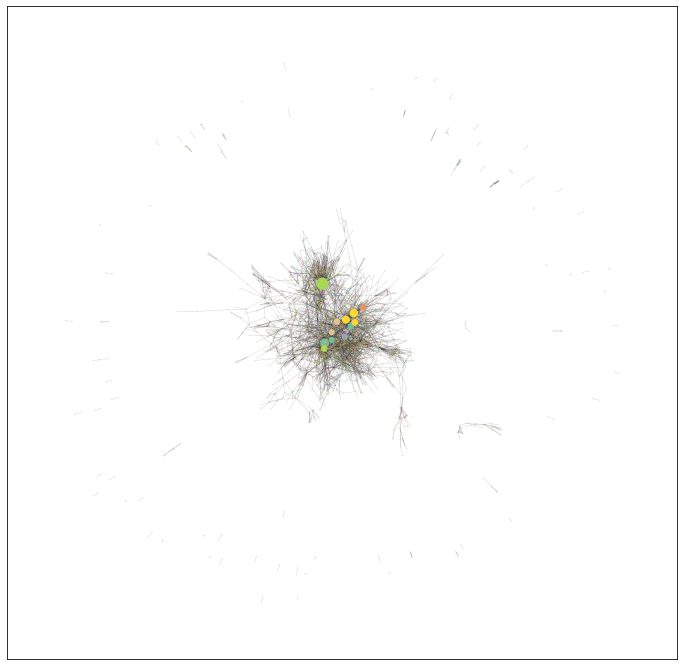

In [ ]:
import numpy as np
node_size = list(map(lambda x: x*2000 , cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, 
                               pos, 
                               node_size=node_size,
                               cmap="Set2",
                               node_color=list(cent.keys()),
                               nodelist=list(cent.keys()),
                               alpha=cent_bin
                               )
edges = nx.draw_networkx_edges(G, 
                               pos, 
                               width=0.25, 
                               alpha=0.3
                               )
plt.show()

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model_MLP = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def trainMLP():
      model_MLP.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model_MLP(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testMLP():
      model_MLP.eval()
      out = model_MLP(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

<IPython.core.display.Javascript object>

In [ ]:
data.x.shape

torch.Size([2708, 1433])

In [ ]:
for epoch in range(1, 201):
    loss = trainMLP()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

modelCNN = CNN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.



<IPython.core.display.Javascript object>

In [ ]:
def trainCNN():
      modelCNN.train()
      optimizer.zero_grad()  # Clear gradients.
      x_train = data.x.reshape(-1, data.x.shape[1], 1)
      out = modelCNN(x_train).reshape(-1, dataset.num_classes)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testCNN():
      modelCNN.eval()
      x_test = data.x.reshape(-1, data.x.shape[1], 1)
      out = modelCNN(x_test).reshape(-1, dataset.num_classes)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

In [ ]:
data.x.shape

torch.Size([2708, 1433])

In [ ]:
temp = data.x.reshape(-1, data.x.shape[1], 1)
temp.shape

torch.Size([2708, 1433, 1])

In [ ]:
out = model(temp)

In [ ]:
out.reshape(-1, 7).shape

torch.Size([2708, 7])

In [ ]:
criterion(out.reshape(-1, 7)[data.train_mask], data.y[data.train_mask])

tensor(1.9615, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(1, 201):
    loss = trainCNN()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9616
Epoch: 002, Loss: 1.9564
Epoch: 003, Loss: 1.9495
Epoch: 004, Loss: 1.9419
Epoch: 005, Loss: 1.9369
Epoch: 006, Loss: 1.9244
Epoch: 007, Loss: 1.9196
Epoch: 008, Loss: 1.9131
Epoch: 009, Loss: 1.9019
Epoch: 010, Loss: 1.8895
Epoch: 011, Loss: 1.8737
Epoch: 012, Loss: 1.8616
Epoch: 013, Loss: 1.8539
Epoch: 014, Loss: 1.8458
Epoch: 015, Loss: 1.8197
Epoch: 016, Loss: 1.8194
Epoch: 017, Loss: 1.8027
Epoch: 018, Loss: 1.7732
Epoch: 019, Loss: 1.7733
Epoch: 020, Loss: 1.7491
Epoch: 021, Loss: 1.7472
Epoch: 022, Loss: 1.7194
Epoch: 023, Loss: 1.6962
Epoch: 024, Loss: 1.6584
Epoch: 025, Loss: 1.6668
Epoch: 026, Loss: 1.6226
Epoch: 027, Loss: 1.6333
Epoch: 028, Loss: 1.6029
Epoch: 029, Loss: 1.5534
Epoch: 030, Loss: 1.5783
Epoch: 031, Loss: 1.5381
Epoch: 032, Loss: 1.5213
Epoch: 033, Loss: 1.4926
Epoch: 034, Loss: 1.4652
Epoch: 035, Loss: 1.4754
Epoch: 036, Loss: 1.4559
Epoch: 037, Loss: 1.3932
Epoch: 038, Loss: 1.3604
Epoch: 039, Loss: 1.3321
Epoch: 040, Loss: 1.3120


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [ ]:
test_acc = testMLP()
print(f'Test Accuracy (MLP): {test_acc:.4f}')

Test Accuracy (MLP): 0.5900


In [ ]:
test_acc = testCNN()
print(f'Test Accuracy (CNN): {test_acc:.4f}')

Test Accuracy (CNN): 0.6040


As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


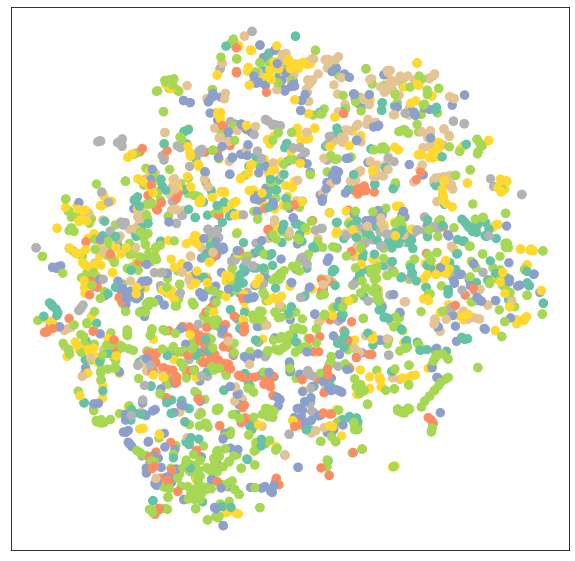

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

modelGCN = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(modelGCN.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def trainGCN():
      modelGCN.train()
      optimizer.zero_grad()  # Clear gradients.
      out = modelGCN(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testGCN():
      modelGCN.eval()
      out = modelGCN(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = trainGCN()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


After training the model, we can check its test accuracy:

In [ ]:
test_acc = testGCN()
print(f'Test Accuracy (GCN): {test_acc:.4f}')

Test Accuracy (GCN): 0.8150


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


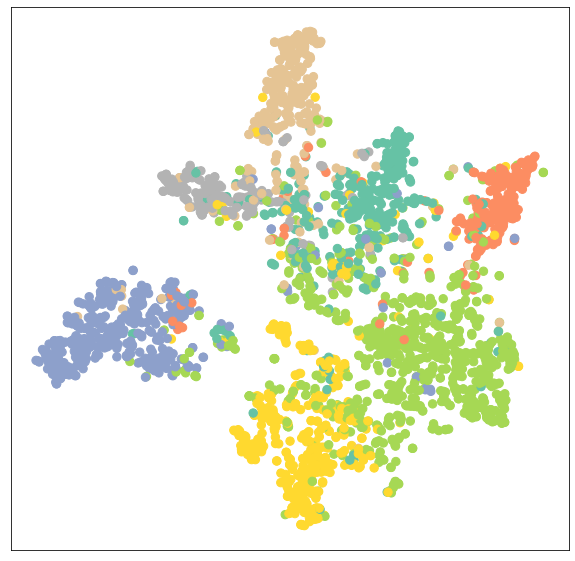

In [ ]:
modelGCN.eval()

out = modelGCN(data.x, data.edge_index)
visualize(out, color=data.y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


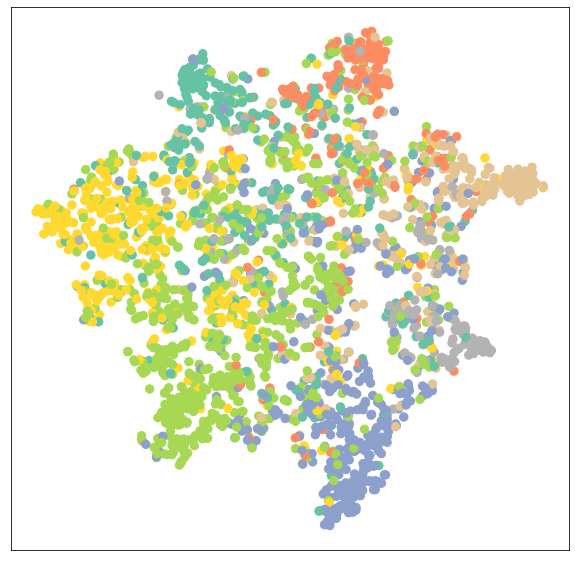

In [ ]:
model_MLP.eval()

out = model_MLP(data.x)
visualize(out, color=data.y)

## Assignment

1. Make use of the validation set (via `data.val_mask`). Report change in accuracy.

2. Change the number of hidden features.
3. (Optional) Switch out `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

# Validation Data
## Training a MLP

In [ ]:
import torch
from torch.nn import Linear, Conv1d
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=8)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=8, bias=True)
  (lin2): Linear(in_features=8, out_features=7, bias=True)
)


In [ ]:
import torch
from torch.nn import Linear,  Conv1d
import torch.nn.functional as F


class CNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        # self.conv1 = Conv1d(dataset.num_features, hidden_channels, kernel_size = 2)
        self.conv1 = Conv1d(data.num_features, hidden_channels, kernel_size = 1)

        self.conv2 = Conv1d(hidden_channels, dataset.num_classes,  kernel_size = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = x.relu()
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x)
        return x

model = CNN(hidden_channels=8)
print(model)

CNN(
  (conv1): Conv1d(1433, 8, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(8, 7, kernel_size=(1,), stride=(1,))
)


In [ ]:
dataset.num_features

1433

In [ ]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)  # , to_undirected=True
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G) #The degree centrality for a node v is the fraction of nodes it is connected to.

threshold 0.011821204285186553


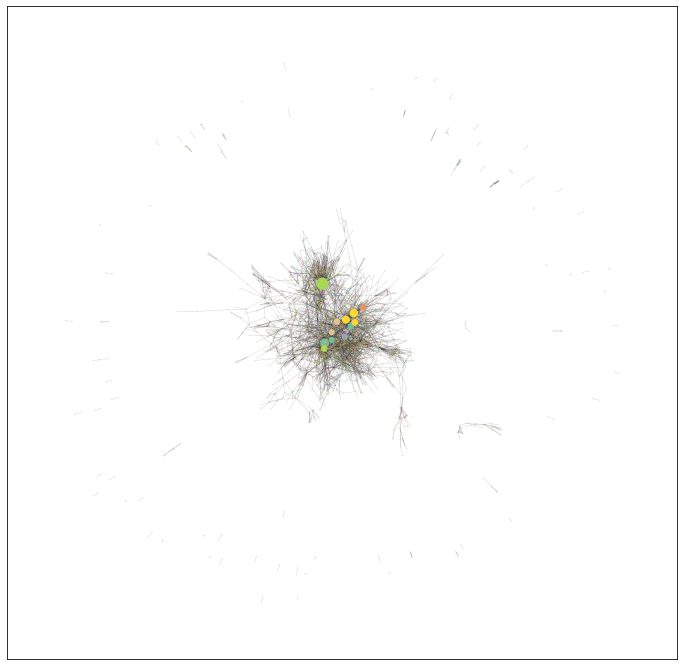

In [ ]:
import numpy as np
node_size = list(map(lambda x: x*2000 , cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, 
                               pos, 
                               node_size=node_size,
                               cmap="Set2",
                               node_color=list(cent.keys()),
                               nodelist=list(cent.keys()),
                               alpha=cent_bin
                               )
edges = nx.draw_networkx_edges(G, 
                               pos, 
                               width=0.25, 
                               alpha=0.3
                               )
plt.show()

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model_MLP = MLP(hidden_channels=8)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def trainMLP():
      model_MLP.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model_MLP(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testMLP():
      model_MLP.eval()
      out = model_MLP(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def valMLP():
      model_MLP.eval()
      out = model_MLP(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return val_acc

<IPython.core.display.Javascript object>

In [ ]:
data.x.shape

torch.Size([2708, 1433])

In [ ]:
for epoch in range(1, 201):
    loss = trainMLP()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9622
Epoch: 002, Loss: 1.9591
Epoch: 003, Loss: 1.9573
Epoch: 004, Loss: 1.9546
Epoch: 005, Loss: 1.9518
Epoch: 006, Loss: 1.9489
Epoch: 007, Loss: 1.9447
Epoch: 008, Loss: 1.9420
Epoch: 009, Loss: 1.9346
Epoch: 010, Loss: 1.9306
Epoch: 011, Loss: 1.9272
Epoch: 012, Loss: 1.9211
Epoch: 013, Loss: 1.9161
Epoch: 014, Loss: 1.9146
Epoch: 015, Loss: 1.9075
Epoch: 016, Loss: 1.8961
Epoch: 017, Loss: 1.8945
Epoch: 018, Loss: 1.8814
Epoch: 019, Loss: 1.8847
Epoch: 020, Loss: 1.8703
Epoch: 021, Loss: 1.8627
Epoch: 022, Loss: 1.8634
Epoch: 023, Loss: 1.8522
Epoch: 024, Loss: 1.8532
Epoch: 025, Loss: 1.8333
Epoch: 026, Loss: 1.8091
Epoch: 027, Loss: 1.8223
Epoch: 028, Loss: 1.8175
Epoch: 029, Loss: 1.8000
Epoch: 030, Loss: 1.7747
Epoch: 031, Loss: 1.7564
Epoch: 032, Loss: 1.7696
Epoch: 033, Loss: 1.7666
Epoch: 034, Loss: 1.7418
Epoch: 035, Loss: 1.7315
Epoch: 036, Loss: 1.7244
Epoch: 037, Loss: 1.7415
Epoch: 038, Loss: 1.7183
Epoch: 039, Loss: 1.6890
Epoch: 040, Loss: 1.6913


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

modelCNN = CNN(hidden_channels=8)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

<IPython.core.display.Javascript object>

In [ ]:
def trainCNN():
      modelCNN.train()
      optimizer.zero_grad()  # Clear gradients.
      x_train = data.x.reshape(-1, data.x.shape[1], 1)
      out = modelCNN(x_train).reshape(-1, dataset.num_classes)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testCNN():
      modelCNN.eval()
      x_test = data.x.reshape(-1, data.x.shape[1], 1)
      out = modelCNN(x_test).reshape(-1, dataset.num_classes)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def valCNN():
   modelCNN.eval()
   x_val = data.x.reshape(-1,data.x.shape[1],1)
   out = modelCNN(x_val).reshape(-1, dataset.num_classes)
   pred = out.argmax(dim=1)
   val_correct = pred[data.val_mask] == data.y[data.val_mask]
   val_acc  = int(val_correct.sum()) / int(data.val_mask.sum())
   return val_acc
  
      


In [ ]:
data.x.shape

torch.Size([2708, 1433])

In [ ]:
temp = data.x.reshape(-1, data.x.shape[1], 1)
temp.shape

torch.Size([2708, 1433, 1])

In [ ]:
out = model(temp)

In [ ]:
out.reshape(-1, 7).shape

torch.Size([2708, 7])

In [ ]:
criterion(out.reshape(-1, 7)[data.train_mask], data.y[data.train_mask])

tensor(1.9622, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(1, 201):
    loss = trainCNN()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9612
Epoch: 002, Loss: 1.9593
Epoch: 003, Loss: 1.9567
Epoch: 004, Loss: 1.9543
Epoch: 005, Loss: 1.9514
Epoch: 006, Loss: 1.9474
Epoch: 007, Loss: 1.9442
Epoch: 008, Loss: 1.9378
Epoch: 009, Loss: 1.9328
Epoch: 010, Loss: 1.9323
Epoch: 011, Loss: 1.9280
Epoch: 012, Loss: 1.9193
Epoch: 013, Loss: 1.9197
Epoch: 014, Loss: 1.9113
Epoch: 015, Loss: 1.9057
Epoch: 016, Loss: 1.9008
Epoch: 017, Loss: 1.8973
Epoch: 018, Loss: 1.8936
Epoch: 019, Loss: 1.8795
Epoch: 020, Loss: 1.8757
Epoch: 021, Loss: 1.8699
Epoch: 022, Loss: 1.8693
Epoch: 023, Loss: 1.8693
Epoch: 024, Loss: 1.8465
Epoch: 025, Loss: 1.8298
Epoch: 026, Loss: 1.8409
Epoch: 027, Loss: 1.8340
Epoch: 028, Loss: 1.8236
Epoch: 029, Loss: 1.7943
Epoch: 030, Loss: 1.7816
Epoch: 031, Loss: 1.7906
Epoch: 032, Loss: 1.7923
Epoch: 033, Loss: 1.7819
Epoch: 034, Loss: 1.7531
Epoch: 035, Loss: 1.7450
Epoch: 036, Loss: 1.7712
Epoch: 037, Loss: 1.7511
Epoch: 038, Loss: 1.7237
Epoch: 039, Loss: 1.7250
Epoch: 040, Loss: 1.7225


In [ ]:
test_acc = testMLP()
print(f'Test Accuracy (MLP): {test_acc:.4f}')

Test Accuracy (MLP): 0.4960


In [ ]:
val_acc = valMLP()
print(f'Validation Accuracy (MLP): {val_acc:.4f}')

Validation Accuracy (MLP): 0.2450


In [ ]:
test_acc = testCNN()
print(f'Test Accuracy (CNN): {test_acc:.4f}')

Test Accuracy (CNN): 0.4770


In [ ]:
val_acc = valCNN()
print(f'Validation Accuracy (CNN): {val_acc:.4f}')

Validation Accuracy (CNN): 0.4900


# Training a Graph Neural Network

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=8)
print(model)

GCN(
  (conv1): GCNConv(1433, 8)
  (conv2): GCNConv(8, 7)
)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


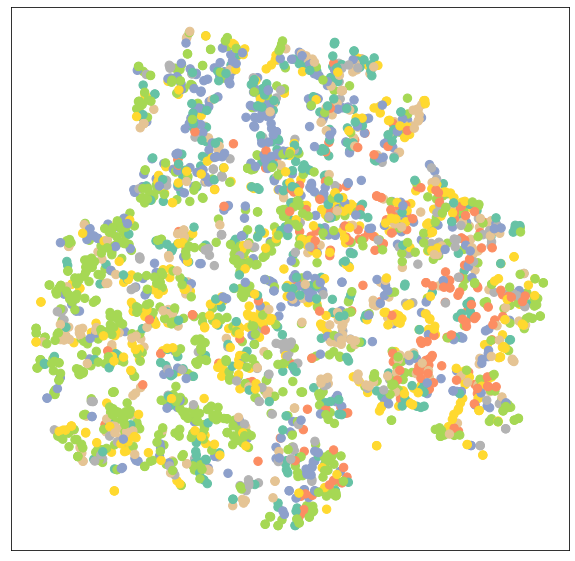

In [ ]:
model = GCN(hidden_channels=8)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

modelGCN = GCN(hidden_channels=8)
optimizer = torch.optim.Adam(modelGCN.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def trainGCN():
      modelGCN.train()
      optimizer.zero_grad()  # Clear gradients.
      out = modelGCN(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testGCN():
      modelGCN.eval()
      out = modelGCN(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def valGCN():
      modelGCN.eval()
      out = modelGCN(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      return val_acc


for epoch in range(1, 101):
    loss = trainGCN()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9457
Epoch: 002, Loss: 1.9422
Epoch: 003, Loss: 1.9368
Epoch: 004, Loss: 1.9329
Epoch: 005, Loss: 1.9265
Epoch: 006, Loss: 1.9228
Epoch: 007, Loss: 1.9156
Epoch: 008, Loss: 1.9125
Epoch: 009, Loss: 1.9050
Epoch: 010, Loss: 1.8973
Epoch: 011, Loss: 1.8911
Epoch: 012, Loss: 1.8904
Epoch: 013, Loss: 1.8769
Epoch: 014, Loss: 1.8681
Epoch: 015, Loss: 1.8604
Epoch: 016, Loss: 1.8611
Epoch: 017, Loss: 1.8568
Epoch: 018, Loss: 1.8390
Epoch: 019, Loss: 1.8328
Epoch: 020, Loss: 1.8334
Epoch: 021, Loss: 1.8060
Epoch: 022, Loss: 1.8114
Epoch: 023, Loss: 1.7947
Epoch: 024, Loss: 1.7858
Epoch: 025, Loss: 1.7875
Epoch: 026, Loss: 1.7675
Epoch: 027, Loss: 1.7730
Epoch: 028, Loss: 1.7519
Epoch: 029, Loss: 1.7435
Epoch: 030, Loss: 1.7325
Epoch: 031, Loss: 1.7188
Epoch: 032, Loss: 1.7043
Epoch: 033, Loss: 1.6753
Epoch: 034, Loss: 1.6774
Epoch: 035, Loss: 1.6609
Epoch: 036, Loss: 1.6646
Epoch: 037, Loss: 1.6502
Epoch: 038, Loss: 1.6510
Epoch: 039, Loss: 1.6333
Epoch: 040, Loss: 1.6063


In [ ]:
test_acc = testGCN()
print(f'Test Accuracy (GCN): {test_acc:.4f}')

Test Accuracy (GCN): 0.7720


In [ ]:
val_acc = valGCN()
print(f'Validation Accuracy (GCN): {val_acc:.4f}')

Validation Accuracy (GCN): 0.7500


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


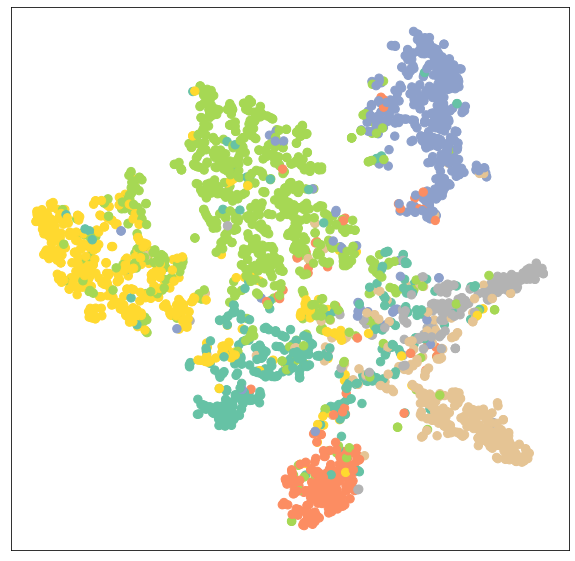

In [ ]:
modelGCN.eval()

out = modelGCN(data.x, data.edge_index)
visualize(out, color=data.y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


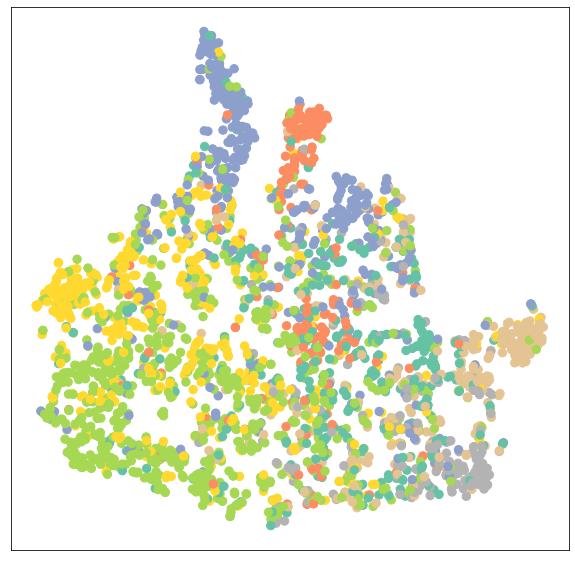

In [ ]:
model_MLP.eval()

out = model_MLP(data.x)
visualize(out, color=data.y)

# Changing hidden feature and dropout

In [ ]:
import torch
from torch.nn import Linear, Conv1d
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
import torch
from torch.nn import Linear,  Conv1d
import torch.nn.functional as F


class CNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        # self.conv1 = Conv1d(dataset.num_features, hidden_channels, kernel_size = 2)
        self.conv1 = Conv1d(data.num_features, hidden_channels, kernel_size = 1)

        self.conv2 = Conv1d(hidden_channels, dataset.num_classes,  kernel_size = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x)
        return x

model = CNN(hidden_channels=8)
print(model)

CNN(
  (conv1): Conv1d(1433, 16, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(16, 7, kernel_size=(1,), stride=(1,))
)


In [ ]:
dataset.num_features

1433

In [ ]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)  # , to_undirected=True
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G) #The degree centrality for a node v is the fraction of nodes it is connected to.

threshold 0.011821204285186553


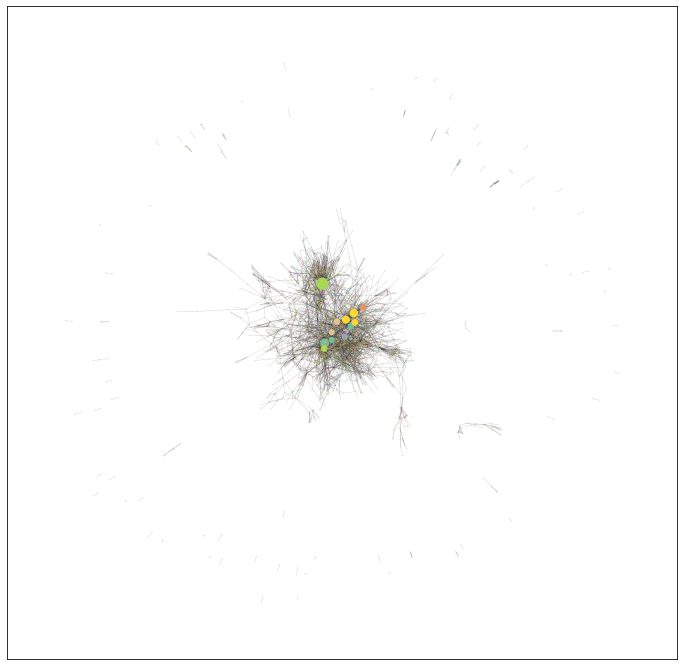

In [ ]:
import numpy as np
node_size = list(map(lambda x: x*2000 , cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, 
                               pos, 
                               node_size=node_size,
                               cmap="Set2",
                               node_color=list(cent.keys()),
                               nodelist=list(cent.keys()),
                               alpha=cent_bin
                               )
edges = nx.draw_networkx_edges(G, 
                               pos, 
                               width=0.25, 
                               alpha=0.3
                               )
plt.show()

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model_MLP = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def trainMLP():
      model_MLP.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model_MLP(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testMLP():
      model_MLP.eval()
      out = model_MLP(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def valMLP():
      model_MLP.eval()
      out = model_MLP(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return val_acc

<IPython.core.display.Javascript object>

In [ ]:
data.x.shape

torch.Size([2708, 1433])

In [ ]:
for epoch in range(1, 201):
    loss = trainMLP()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

modelCNN = CNN(hidden_channels=8)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

<IPython.core.display.Javascript object>

In [ ]:
def trainCNN():
      modelCNN.train()
      optimizer.zero_grad()  # Clear gradients.
      x_train = data.x.reshape(-1, data.x.shape[1], 1)
      out = modelCNN(x_train).reshape(-1, dataset.num_classes)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testCNN():
      modelCNN.eval()
      x_test = data.x.reshape(-1, data.x.shape[1], 1)
      out = modelCNN(x_test).reshape(-1, dataset.num_classes)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def valCNN():
   modelCNN.eval()
   x_val = data.x.reshape(-1,data.x.shape[1],1)
   out = modelCNN(x_val).reshape(-1, dataset.num_classes)
   pred = out.argmax(dim=1)
   val_correct = pred[data.val_mask] == data.y[data.val_mask]
   val_acc  = int(val_correct.sum()) / int(data.val_mask.sum())
   return val_acc

In [ ]:
data.x.shape

torch.Size([2708, 1433])

In [ ]:
temp = data.x.reshape(-1, data.x.shape[1], 1)
temp.shape

torch.Size([2708, 1433, 1])

In [ ]:
out = model(temp)

In [ ]:
out.reshape(-1, 7).shape

torch.Size([2708, 7])

In [ ]:
criterion(out.reshape(-1, 7)[data.train_mask], data.y[data.train_mask])

tensor(1.9622, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(1, 201):
    loss = trainCNN()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9613
Epoch: 002, Loss: 1.9592
Epoch: 003, Loss: 1.9571
Epoch: 004, Loss: 1.9541
Epoch: 005, Loss: 1.9514
Epoch: 006, Loss: 1.9473
Epoch: 007, Loss: 1.9421
Epoch: 008, Loss: 1.9374
Epoch: 009, Loss: 1.9317
Epoch: 010, Loss: 1.9288
Epoch: 011, Loss: 1.9252
Epoch: 012, Loss: 1.9171
Epoch: 013, Loss: 1.9160
Epoch: 014, Loss: 1.9085
Epoch: 015, Loss: 1.9004
Epoch: 016, Loss: 1.8984
Epoch: 017, Loss: 1.8934
Epoch: 018, Loss: 1.8885
Epoch: 019, Loss: 1.8726
Epoch: 020, Loss: 1.8637
Epoch: 021, Loss: 1.8646
Epoch: 022, Loss: 1.8577
Epoch: 023, Loss: 1.8548
Epoch: 024, Loss: 1.8358
Epoch: 025, Loss: 1.8158
Epoch: 026, Loss: 1.8261
Epoch: 027, Loss: 1.8131
Epoch: 028, Loss: 1.8040
Epoch: 029, Loss: 1.7880
Epoch: 030, Loss: 1.7667
Epoch: 031, Loss: 1.7722
Epoch: 032, Loss: 1.7694
Epoch: 033, Loss: 1.7613
Epoch: 034, Loss: 1.7229
Epoch: 035, Loss: 1.7393
Epoch: 036, Loss: 1.7303
Epoch: 037, Loss: 1.7325
Epoch: 038, Loss: 1.6948
Epoch: 039, Loss: 1.6943
Epoch: 040, Loss: 1.7034


In [ ]:
test_acc = testMLP()
print(f'Test Accuracy (MLP): {test_acc:.4f}')

Test Accuracy (MLP): 0.5900


In [ ]:
val_acc = valMLP()
print(f'Validation Accuracy (MLP): {val_acc:.4f}')

Validation Accuracy (MLP): 0.2960


In [ ]:
test_acc = testCNN()
print(f'Test Accuracy (CNN): {test_acc:.4f}')

Test Accuracy (CNN): 0.4820


In [ ]:
val_acc = valCNN()
print(f'Validation Accuracy (CNN): {val_acc:.4f}')

Validation Accuracy (CNN): 0.4920


# Train a Graph neural Network

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


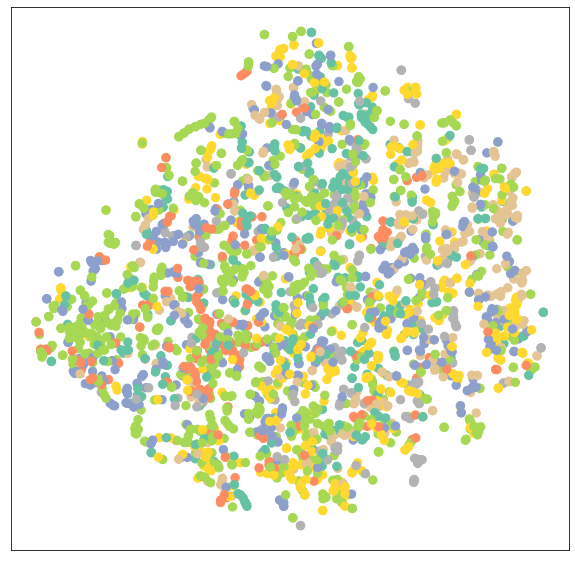

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

modelGCN = GCN(hidden_channels=8)
optimizer = torch.optim.Adam(modelGCN.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def trainGCN():
      modelGCN.train()
      optimizer.zero_grad()  # Clear gradients.
      out = modelGCN(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def testGCN():
      modelGCN.eval()
      out = modelGCN(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def valGCN():
      modelGCN.eval()
      out = modelGCN(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      return val_acc


for epoch in range(1, 101):
    loss = trainGCN()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9457
Epoch: 002, Loss: 1.9435
Epoch: 003, Loss: 1.9396
Epoch: 004, Loss: 1.9365
Epoch: 005, Loss: 1.9314
Epoch: 006, Loss: 1.9275
Epoch: 007, Loss: 1.9213
Epoch: 008, Loss: 1.9204
Epoch: 009, Loss: 1.9110
Epoch: 010, Loss: 1.9042
Epoch: 011, Loss: 1.8973
Epoch: 012, Loss: 1.8965
Epoch: 013, Loss: 1.8850
Epoch: 014, Loss: 1.8803
Epoch: 015, Loss: 1.8696
Epoch: 016, Loss: 1.8738
Epoch: 017, Loss: 1.8701
Epoch: 018, Loss: 1.8496
Epoch: 019, Loss: 1.8433
Epoch: 020, Loss: 1.8444
Epoch: 021, Loss: 1.8161
Epoch: 022, Loss: 1.8251
Epoch: 023, Loss: 1.8066
Epoch: 024, Loss: 1.8027
Epoch: 025, Loss: 1.8026
Epoch: 026, Loss: 1.7808
Epoch: 027, Loss: 1.7946
Epoch: 028, Loss: 1.7662
Epoch: 029, Loss: 1.7628
Epoch: 030, Loss: 1.7593
Epoch: 031, Loss: 1.7420
Epoch: 032, Loss: 1.7236
Epoch: 033, Loss: 1.6878
Epoch: 034, Loss: 1.6995
Epoch: 035, Loss: 1.6739
Epoch: 036, Loss: 1.6816
Epoch: 037, Loss: 1.6717
Epoch: 038, Loss: 1.6724
Epoch: 039, Loss: 1.6617
Epoch: 040, Loss: 1.6252


In [ ]:
test_acc = testGCN()
print(f'Test Accuracy (GCN): {test_acc:.4f}')

Test Accuracy (GCN): 0.7690


In [ ]:
val_acc = valGCN()
print(f'Validation Accuracy (GCN): {val_acc:.4f}')

Validation Accuracy (GCN): 0.7480


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


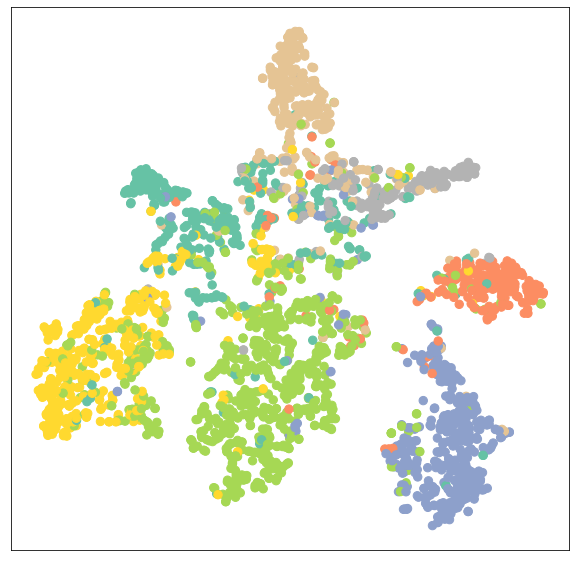

In [ ]:
modelGCN.eval()

out = modelGCN(data.x, data.edge_index)
visualize(out, color=data.y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


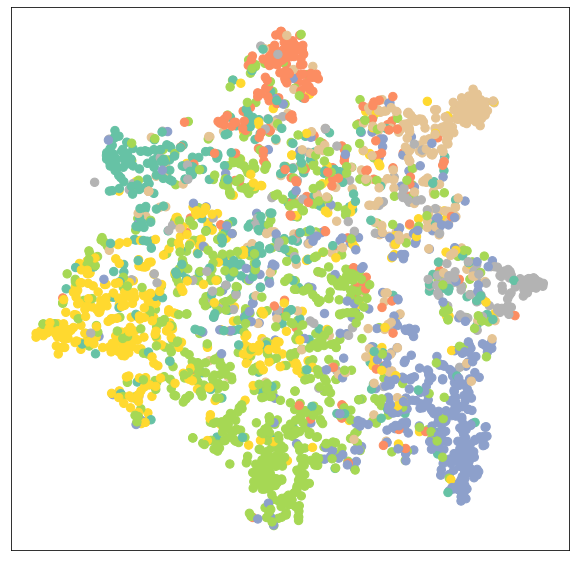

In [ ]:
model_MLP.eval()

out = model_MLP(data.x)
visualize(out, color=data.y)

In [ ]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, kernel_size = 1)  # TODO
        self.conv2 = GATConv(dataset.num_features, hidden_channels, kernel_size = 1)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=1)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=1)
  (conv2): GATConv(1433, 8, heads=1)
)


RuntimeError: ignored